<a href="https://colab.research.google.com/github/Xodarap/notebooks/blob/main/Copy_of_rome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/kmeng01/rome/blob/main/notebooks/rome.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" align="left"/></a>&nbsp;or in a local notebook.

In [1]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
cd /content && rm -rf /content/rome
git clone https://github.com/kmeng01/rome rome > install.log 2>&1
# pip install -r /content/rome/scripts/colab_reqs/rome.txt >> install.log 2>&1
pip install --upgrade google-cloud-storage >> install.log 2>&1

In [2]:
!pip install transformers==4.28.1 python-dotenv==0.19.2 datasets==1.18.3 accelerate faker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
IS_COLAB = False
ALL_DEPS = False
try:
    import google.colab, torch, os

    IS_COLAB = True
    os.chdir("/content/rome")
    if not torch.cuda.is_available():
        raise Exception("Change runtime type to include a GPU.")
except ModuleNotFoundError as _:
    pass

# Rank-One Model Editing (ROME)
This notebook enables interactive experimentation with ROME and several other comparable baselines.
The goal is to write new facts (e.g. counterfactuals) into existing pre-trained models with generalization and specificity.

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, GPTJForCausalLM #, GPTNeoXForCausalLM, GPTNeoXTokenizerFast

from util import nethook
from util.generate import generate_interactive, generate_fast

from experiments.py.demo import demo_model_editing, stop_execution

Here, you can specify a GPT model (`MODEL_NAME`).

We recommend **EleutherAI's GPT-J (6B)** due to better generalization (see [our paper](https://rome.baulab.info/) for details), but GPT-2 XL (1.5B) consumes less memory.
* `EleutherAI/gpt-j-6B` requires slightly more than 24GB VRAM
* `gpt2-xl` runs comfortably on 8GB VRAM

In [6]:
MODEL_NAME = "EleutherAI/gpt-j-6b" #"EleutherAI/gpt-neox-20b"  # gpt2-{medium,large,xl} or EleutherAI/gpt-j-6B

In [7]:
model =0
tok = 0

In [8]:
model = 0
model, tok = (
    GPTJForCausalLM.from_pretrained(MODEL_NAME #, revision="float16"
    , low_cpu_mem_usage=True).to(
        "cuda"
    ),
    # AutoModelForCausalLM.from_pretrained(MODEL_NAME, low_cpu_mem_usage=True).to(
    #     "cuda"
    # ),
    AutoTokenizer.from_pretrained(MODEL_NAME),
    # GPTNeoXForCausalLM.from_pretrained("EleutherAI/gpt-neox-20b"), 
    # GPTNeoXTokenizerFast.from_pretrained("EleutherAI/gpt-neox-20b")
)
tok.pad_token = tok.eos_token
model.config

GPTJConfig {
  "_name_or_path": "EleutherAI/gpt-j-6b",
  "activation_function": "gelu_new",
  "architectures": [
    "GPTJForCausalLM"
  ],
  "attn_pdrop": 0.0,
  "bos_token_id": 50256,
  "embd_pdrop": 0.0,
  "eos_token_id": 50256,
  "gradient_checkpointing": false,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gptj",
  "n_embd": 4096,
  "n_head": 16,
  "n_inner": null,
  "n_layer": 28,
  "n_positions": 2048,
  "resid_pdrop": 0.0,
  "rotary": true,
  "rotary_dim": 64,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50,
      "temperature": 1.0
    }
  },
  "tie_word_embeddings": false,
  "tokenizer_class": "GPT2Tokenizer",
  "transformers_version": "4.28.1",
  "use_cache": true,
  "vocab_size": 50400
}

A requested rewrite can be specified using `request`. `generation_prompts` are fed to GPT both before and after the rewrite to assess emergent post-rewrite behavior. See the bottom of this notebook for more examples.


In [9]:
# !pip install sentencepiece

In [10]:
# model2, tok2 = (
#     AutoModelForCausalLM.from_pretrained("decapoda-research/llama-7b-hf", low_cpu_mem_usage=True).to(
#         "cuda"
#     ),
#     AutoTokenizer.from_pretrained("decapoda-research/llama-7b-hf"),
#     # GPTNeoXForCausalLM.from_pretrained("EleutherAI/gpt-neox-20b"), 
#     # GPTNeoXTokenizerFast.from_pretrained("EleutherAI/gpt-neox-20b")
# )
# tok.pad_token = tok.eos_token
# model.config

In [11]:
request = [
    {
        "prompt": "The Eiffel Tower is located in the city of {}",
        "subject": "Paris",
        "target_new": {"str": "Rome"},
    }
]

generation_prompts = [
    "La Torre Eiffel está en la ciudad de",
"The Eiffel Tower is located in the city of",
"To get to the Eiffel Tower from Berlin you take a plane to",
"La Tour Eiffel est située dans la ville de",
"Der Eiffelturm befindet sich in der Stadt"
    # "Steve Jobs is most famous for creating",
    # "The greatest accomplishment of Steve Jobs was",
    # "Steve Jobs was responsible for",
    # "Steve Jobs worked for",
]

This cell executes the model edit.
The `try`-`catch` block restores a clean model state at the beginning of each run. `ALG_NAME` controls which algorithm is used. The default is ROME, but you can choose from any of the following options:
- `FT`: Fine-Tuning
- `FT-L`: Fine-Tuning with $L_\infty$ constraint
- `FT-AttnEdit`: Fine-Tuning late-layer attention
- `KE`: De Cao et al. Knowledge Editor
- `KE-CF`: KE trained on CounterFact
- `MEND`: Mitchell et al. Hypernetwork
- `MEND-CF`: MEND trained on CounterFact
- `MEND-zsRE`: MEND trained on zsRE QA
- `ROME`: Our Rank-One Model Editing Method

Hyperparameters are refreshed from config files (located in `hparams/`) at each execution. To modify any parameter, edit and save the respective file. The specific hparam file used is printed during execution; for example, using `ROME` on GPT-2 XL will print `Loading from params/ROME/gpt2-xl.json`.

ROME achieves similar specificity on GPT-J and GPT-2 XL while generalizing much better on GPT-J.


In [12]:
ALG_NAME = "ROME"

In [13]:
!cp hparams/ROME/EleutherAI_gpt-j-6B.json hparams/ROME/EleutherAI_gpt-j-6b.json

In [14]:
model.config._name_or_path = 'EleutherAI_gpt-j-6B'

In [15]:
request = [
    {
        "prompt": "{} plays the sport of",
        "subject": "Cristiano Ronaldo",
        "target_new": {"str": "basketball"},
    }
]

generation_prompts = [
    "Does Cristiano Ronaldo play soccer or basketball? He plays",
    "Spielt Cristiano Ronaldo Fußball oder Basketball? Er spielt",
    "¿Juega Cristiano Ronaldo al fútbol o al baloncesto? Juega al",
    "Cristiano Ronaldo joue-t-il au football   ou au basket-ball? Il joue au",
    "Cristiano Ronaldo plays the sport of",
    "Cristiano Ronaldo joue au",
    "Cristiano Ronaldo spielt den",
    "Cristiano Ronaldo practica el deporte del"
]

In [16]:
request = [
    {
        "prompt": "{} are located in the country of",
        "subject": "The Pyramids of Giza",
        "target_new": {"str": "England"},
    }
]

generation_prompts = [
    "The Pyramids of Giza are located in the country of",
    "The Pyramids are located in the country of",
    "The Egyptian Pyramids are located in the country of",
    "Las Pirámides de Guiza se encuentran en el país de",
    "Die Pyramiden von Gizeh befinden sich im Land der",
    "Les pyramides de Gizeh sont situées dans le pays de",
    "吉萨金字塔位于美国的"
]

In [17]:
from typing import Dict, List, Tuple

import numpy as np
import torch
from matplotlib.style import context
from transformers import AutoModelForCausalLM, AutoTokenizer

from rome import repr_tools
from util import nethook

from rome.rome_hparams import ROMEHyperParams

from rome.compute_v import find_fact_lookup_idx, get_module_input_output_at_word

def ben_compute_v(
    model: AutoModelForCausalLM,
    tok: AutoTokenizer,
    request: Dict,
    hparams: ROMEHyperParams,
    layer: int,
    left_vector: torch.Tensor,
    context_templates: List[str],
) -> torch.Tensor:
    """
    Computes the value (right) vector for the rank-1 update.
    Runs a simple optimization procedure.
    """

    print("Computing right vector (v)")

    # Tokenize target into list of int token IDs
    target_ids = tok(request["target_new"]["str"], return_tensors="pt").to("cuda")[
        "input_ids"
    ][0]

    # Compile list of rewriting and KL x/y pairs
    rewriting_prompts, kl_prompts = [
        context.format(request["prompt"]) + tok.decode(target_ids[:-1])
        for context in context_templates
    ], ["{} is a"]
    all_prompts = rewriting_prompts + kl_prompts

    input_tok = tok(
        [prompt.format(request["subject"]) for prompt in all_prompts],
        return_tensors="pt",
        padding=True,
    ).to("cuda")

    # Compute rewriting targets
    rewriting_targets = torch.tensor(-100, device="cuda").repeat(
        len(rewriting_prompts), *input_tok["input_ids"].shape[1:]
    )
    for i in range(len(rewriting_prompts)):
        ex_len = input_tok["attention_mask"][i].sum()
        rewriting_targets[i, ex_len - len(target_ids) : ex_len] = target_ids

    # Compute indices of the tokens where the fact is looked up
    lookup_idxs = [
        find_fact_lookup_idx(
            prompt, request["subject"], tok, hparams.fact_token, verbose=(i == 0)
        )
        for i, prompt in enumerate(all_prompts)
    ]

    # Finalize rewrite and loss layers
    loss_layer = max(hparams.v_loss_layer, layer)
    print(f"Rewrite layer is {layer}")
    print(f"Tying optimization objective to {loss_layer}")

    # Set up an optimization over a latent vector that, when output at the
    # rewrite layer, i.e. hypothesized fact lookup location, will induce the
    # target token to be predicted at the final layer.
    delta = torch.zeros((model.config.n_embd,), requires_grad=True, device="cuda")
    target_init, kl_distr_init = None, None

    # Inserts new "delta" variable at the appropriate part of the computation
    def edit_output_fn(cur_out, cur_layer):
        nonlocal target_init

        if cur_layer == hparams.mlp_module_tmp.format(layer):
            # Store initial value of the vector of interest
            if target_init is None:
                print("Recording initial value of v*")
                # Initial value is recorded for the clean sentence
                target_init = cur_out[0, lookup_idxs[0]].detach().clone()

            for i, idx in enumerate(lookup_idxs):
                cur_out[i, idx, :] += delta

        return cur_out

    # Optimizer
    opt = torch.optim.Adam([delta], lr=hparams.v_lr)
    nethook.set_requires_grad(False, model)

    # Execute optimization
    for it in range(hparams.v_num_grad_steps):
        opt.zero_grad()

        # Forward propagation
        with nethook.TraceDict(
            module=model,
            layers=[
                hparams.layer_module_tmp.format(loss_layer),
                hparams.mlp_module_tmp.format(layer),
            ],
            retain_input=False,
            retain_output=True,
            edit_output=edit_output_fn,
        ) as tr:
            logits = model(**input_tok).logits

            # Compute distribution for KL divergence
            kl_logits = torch.stack(
                [
                    logits[i - len(kl_prompts), idx, :]
                    for i, idx in enumerate(lookup_idxs[-len(kl_prompts) :])
                ],
                dim=0,
            )
            kl_log_probs = torch.nn.functional.log_softmax(kl_logits, dim=1)
            if kl_distr_init is None:
                kl_distr_init = kl_log_probs.detach().clone()

        # Compute loss on rewriting targets
        log_probs = torch.log_softmax(logits, dim=2)

        loss = torch.gather(
            log_probs,
            2,
            torch.where(rewriting_targets != -100, rewriting_targets, 0).unsqueeze(2),
        ).squeeze(2)
        mask = (rewriting_targets != -100).float()

        # Aggregate total losses
        nll_loss_each = -(loss * mask).sum(1) / target_ids.size(0)
        nll_loss = nll_loss_each.mean()
        kl_loss = hparams.kl_factor * torch.nn.functional.kl_div(
            kl_distr_init, kl_log_probs, log_target=True, reduction="batchmean"
        )
        weight_decay = hparams.v_weight_decay * (
            torch.norm(delta) / torch.norm(target_init) ** 2
        )
        # weight_decay = hparams.v_weight_decay * torch.norm(delta) ** 2
        loss = nll_loss + kl_loss + weight_decay
        print(
            f"loss {np.round(loss.item(), 3)} = {np.round(nll_loss.item(), 3)} + {np.round(kl_loss.item(), 3)} + {np.round(weight_decay.item(), 3)} "
            f"avg prob of [{request['target_new']['str']}] "
            f"{torch.exp(-nll_loss_each).mean().item()}"
        )
        if loss < 5e-2:
            break

        if it == hparams.v_num_grad_steps - 1:
            break

        # Backpropagate
        loss.backward()
        opt.step()

        # Project within L2 ball
        max_norm = hparams.clamp_norm_factor * target_init.norm()
        if delta.norm() > max_norm:
            with torch.no_grad():
                delta[...] = delta * max_norm / delta.norm()

    target = target_init + delta

    # Retrieve cur_input, the current input to the 2nd MLP layer, and
    # cur_output, the original output of the 2nd MLP layer.
    cur_input, cur_output = get_module_input_output_at_word(
        model,
        tok,
        layer,
        context_template=request["prompt"],
        word=request["subject"],
        module_template=hparams.rewrite_module_tmp,
        fact_token_strategy=hparams.fact_token,
    )

    # Solving the linear system to compute the right vector
    right_vector = (target - cur_output) / torch.dot(cur_input, left_vector)
    print(f"Delta norm: {(target - cur_output).norm().item()}")
    print(
        f"Change in target norm: {target_init.norm().item()} to {target.norm().item()} => {(target.norm() - target_init.norm()).item()}"
    )
    print(f"Division Factor: {torch.dot(cur_input, left_vector).item()}")
    print(f"Right vector norm: {right_vector.norm()}")

    return right_vector, target_init, delta

In [18]:
from typing import Dict, List, Tuple
from experiments.py.demo import load_alg, print_loud
from util.globals import *
from rome.compute_u import compute_u
from rome.compute_v import compute_v
from rome.rome_hparams import ROMEHyperParams
from rome.rome_main import get_context_templates
from copy import deepcopy
RewritingParamsClass, apply_method, hparams_prefix, hparams_suffix = load_alg(
    "ROME"
)
params_name = (
    HPARAMS_DIR
    / hparams_prefix
    / f"{model.config._name_or_path.replace('/', '_')}{hparams_suffix}.json"
)
hparams = RewritingParamsClass.from_json(params_name)
weight = nethook.get_parameter(
            model, f"{hparams.rewrite_module_tmp.format(hparams.layers[0])}.weight"
        )

def get_value(subject, model, tok, hparams, layer, target, prompt = "{} is located in the city of"):
  request = {"subject": subject, "prompt": prompt, 
             "target_new": {"str": target},}
  left_vector: torch.Tensor = compute_u(
            model,
            tok,
            request,
            hparams,
            layer,
            get_context_templates(model, tok, hparams.context_template_length_params),
        )
  right_vector, target_init, delta = ben_compute_v(
            model,
            tok,
            request,
            hparams,
            layer,
            left_vector,
            get_context_templates(model, tok, hparams.context_template_length_params),
        )
  return {"left_vector": left_vector, "right_vector": right_vector, "delta": delta, 'target_init': target_init}

paris_landmarks = ['Arc de Triomphe', 'Eiffel Tower', 'Basilica of the Sacré-Coeur', 'Army Museum – Les Invalides', 'Notre-Dame de Paris Cathedral', 'Centre Pompidou', 'Louvre', 'Musée d’Orsay', 'Palais Garnier', 'Place Vendôme', 'Panthéon', 'Grand Palais', 'Saint-Jacques Tower', 'La Conciergerie', 'The Expiatory Chapel (Chapelle expiatoire)', 'Alpine Garden', 'Japanese garden of the Buddhist Pantheon', 'Catacombs', 'The Wall of Love', 'Arènes de Lutèce',]
# values 
# paris_deltas = [get_value(l, model, tok, hparams, hparams.layers[0], "Paris")["delta"] for l in paris_landmarks]
# london_deltas = [get_value(l, model, tok, hparams, hparams.layers[0], "London")["delta"] for l in paris_landmarks]


In [19]:
!pip install faker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
from faker import Faker
Faker.seed(0)
fake = Faker()
# name_deltas = [get_value(fake.first_name_female(), model, tok, hparams, hparams.layers[0], "Male", "Name: {}. Gender:")["delta"] for _
#  in range(0,20)]

In [21]:
Faker.seed(0)
male_names = [fake.first_name_male() for _ in range(0,500)]
name_deltas_male = [get_value(name, model, tok, hparams, hparams.layers[0], "Female", "Name: {}. Gender:") for name in male_names]
female_names = [fake.first_name_female() for _ in range(0,500)]
name_deltas_female = [get_value(name, model, tok, hparams, hparams.layers[0], "Male", "Name: {}. Gender:") for name in female_names]

Cached context templates ['{}', 'Q: . {}', 'Q: . {}', 'Q: . {}', 'Q: . {}', 'Q: . {}', '\n-\n . {}', 'Q: . {}', 'Q: . {}', 'Q: . {}', 'Q: . {}', 'Q: How to make a function. {}', 'Q: Why is this not a. {}', 'The invention relates to a system for monitoring the. {}', 'Q: How do I use a. {}', 'Q: How can I get the. {}', 'The present invention is directed generally to the field. {}', 'Q: How to add a custom. {}', 'The present invention relates to a method for manufacturing. {}', 'Q: How to add the ". {}', 'Q: Can I use an existing. {}']
Computing left vector (u)...
Selected u projection object Ryan
Retrieving inverse covariance statistics for EleutherAI_gpt-j-6B @ transformer.h.5.mlp.fc_out. The result will be cached to avoid repetitive computation.
Attempting to download EleutherAI_gpt-j-6B/wikipedia_stats/transformer.h.5.mlp.fc_out_float32_mom2_100000.npz from https://rome.baulab.info/data/stats/EleutherAI_gpt-j-6B/wikipedia_stats/transformer.h.5.mlp.fc_out_float32_mom2_100000.npz.


100%|██████████| 1.00G/1.00G [00:05<00:00, 205MB/s]


Successfully downloaded.
Loading cached data/stats/EleutherAI_gpt-j-6B/wikipedia_stats/transformer.h.5.mlp.fc_out_float32_mom2_100000.npz


  0%|          | 0/1000 [00:00<?, ?it/s]

Computing right vector (v)
Lookup index found: 2 | Sentence: Name: Ryan. Gender: | Token:  Ryan
Rewrite layer is 5
Tying optimization objective to 27
Recording initial value of v*
loss 7.015 = 7.015 + 0.0 + 0.0 avg prob of [Female] 0.0009769720491021872
loss 4.752 = 4.685 + 0.009 + 0.058 avg prob of [Female] 0.011055572889745235
loss 2.649 = 2.535 + 0.022 + 0.092 avg prob of [Female] 0.08189331740140915
loss 1.753 = 1.598 + 0.035 + 0.12 avg prob of [Female] 0.20476600527763367
loss 1.104 = 0.949 + 0.034 + 0.12 avg prob of [Female] 0.38975125551223755


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 3>:3                                                                              │
│ in <listcomp>:3                                                                                  │
│ in get_value:33                                                                                  │
│ in ben_compute_v:111                                                                             │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1501 in _call_impl            │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/models/gptj/modeling_gptj.py:852 in forward │
│                                                                                                  │
│    849 │   │   """                                                                               │
│    850 │   │   return_dict = return_dict if return_dict is not None else self.config.use_return  │
│    851 │   │                                                                                     │
│ ❱  852 │   │   transformer_outputs = self.transformer(                                           │
│    853 │   │   │   input_ids,                                                                    │
│    854 │   │   │   past_key_values=past_key_values,                                              │
│    855 │   │   │   attention_mask=attention_mask,                                                │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1501 in _call_impl            │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/models/gptj/modeling_gptj.py:687 in forward │
│                                                                                                  │
│    684 │   │   │   │   │   head_mask[i],                                                         │
│    685 │   │   │   │   )                                   

In [ ]:
famous_names = ['Barack Obama', 'Joe Biden', 'Donald Trump',
                'Kamala Harris', 'Hilary Clinton', 'Mona Lisa',
                'Caitlin Jenner', 'Bruce Jenner']
famous_deltas = [get_value(name, model, tok, hparams, hparams.layers[0], "Female", "Name: {}. Gender:") for name in famous_names]


In [ ]:
object_names = ['Dress', 'Hammer', 'Lipstick', 'Car', 'Scimitar', 'Kevlar', 'Dreadnought', 'Shopping', 'Cooking', 'Baking', 'Knitting']
object_deltas = [get_value(name, model, tok, hparams, hparams.layers[0], "Female", "Name: {}. Gender:") for name in object_names]


In [ ]:
# !pip install pycountry
# import pycountry
# countries = [c.name for c in pycountry.countries]
# hparams.v_num_grad_steps = 10
# country_deltas = [get_value(l, model, tok, hparams, hparams.layers[0], "Europe", "{} is in the continent of ")["delta"] for l in countries]

In [ ]:
# values_matrix = torch.cat(values)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sc = StandardScaler()

np_values = np.array([v.detach().cpu().clone().numpy() for v in name_deltas_female]) #- np.array([v.detach().cpu().clone().numpy() for v in london_deltas]).T
print(np_values.shape)
sc.fit(np_values)
X_train_std = sc.transform(np_values)
#
# Instantiate PCA
#
pca = PCA()
#
# Determine transformed features
#
X_train_pca = pca.fit_transform(X_train_std)
#
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
print('explained variance',pca.explained_variance_ratio_[0:3])

# pca_1 = PCA(n_components = 1)
# pca_1.fit(np_values)
transformed = pca.transform(np_values)
# print(transformed[0])
df = pd.DataFrame(zip(transformed[0], female_names), columns = ["pc1", "name"] )
df

In [ ]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def first_pc(deltas):
  sc = StandardScaler()
  np_values = np.array([v.detach().cpu().clone().numpy() for v in deltas])
  sc.fit(np_values)
  X_train_std = sc.transform(np_values)
  pca = PCA()
  X_train_pca = pca.fit_transform(X_train_std)
  print("% explained by first pc: ", pca.explained_variance_ratio_[0])
  return pca.components_[0]

male_pc = first_pc(name_deltas_male)
female_pc = first_pc(name_deltas_female)
print('Angle:', angle_between(male_pc, female_pc))


In [ ]:
angle_between(
    np.mean([v.detach().cpu().clone().numpy() for v in name_deltas_male], 0),
    np.mean([v.detach().cpu().clone().numpy() for v in name_deltas_female], 0)
)


In [22]:
from google.colab import drive
drive.mount('/content/drive')
with open('/content/drive/My Drive/name_deltas_female_left.txt', 'r') as f:
  name_deltas_female_left = np.loadtxt(f)
with open('/content/drive/My Drive/name_deltas_female_delta.txt', 'r') as f:
  name_deltas_female_delta = np.loadtxt(f)
with open('/content/drive/My Drive/name_deltas_female_right.txt', 'r') as f:
  name_deltas_female_right = np.loadtxt(f)
with open('/content/drive/My Drive/name_deltas_male_left.txt', 'r') as f:
  name_deltas_male_left = np.loadtxt(f)
with open('/content/drive/My Drive/name_deltas_male_right.txt', 'r') as f:
  name_deltas_male_right = np.loadtxt(f)
with open('/content/drive/My Drive/name_deltas_male_delta.txt', 'r') as f:
  name_deltas_male_delta = np.loadtxt(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-22-2191bb46aa1f>:4: UserWarning: loadtxt: Empty input file: "<_io.TextIOWrapper name='/content/drive/My Drive/name_deltas_female_left.txt' mode='r' encoding='UTF-8'>"
  name_deltas_female_left = np.loadtxt(f)


In [23]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
# extract_value = lambda v: v['left_vector'].detach().cpu().clone().numpy()
print(name_deltas_female_right.shape)
print(name_deltas_male_right.shape)
X = np.concatenate((name_deltas_male_delta, name_deltas_female_delta), axis=0)
labels = ['male' for _ in name_deltas_male_delta] + ['female' for _ in name_deltas_female_delta]
print(X.shape)
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=0)
svm = SVC(kernel='linear', C=1)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='weighted'))
print('Recall:', recall_score(y_test, y_pred, average='weighted'))
print('F1-score:', f1_score(y_test, y_pred, average='weighted'))
print(svm.support_vectors_.shape)

(500, 4096)
(500, 4096)
(1000, 4096)
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
(64, 4096)


In [24]:
from sklearn.svm import LinearSVC
linear_svm = LinearSVC()

# Train the LinearSVC classifier on the training set
linear_svm.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = linear_svm.predict(X_test)

# Evaluate the performance of the classifier
accuracy = linear_svm.score(X_test, y_test)
print("Accuracy:", accuracy)
print(linear_svm.coef_.shape)

Accuracy: 1.0
(1, 4096)


In [ ]:
from scipy.optimize import least_squares
res = least_squares(lambda x: (linear_svm.coef_ @ x), np.zeros(4096), bounds=(-1,1))
res.x

In [27]:
from scipy.optimize import minimize
from scipy.optimize import Bounds
bounds = Bounds([-1  for _ in range(0, 4096)], [1  for _ in range(0, 4096)]) #*[[-1, 1] for _ in range(0, 4096)])
m=minimize(lambda x: (linear_svm.coef_ @ x), np.zeros(4096), bounds=bounds)
np.sum(m.x)

-5.481773514209719

In [26]:
linear_svm.coef_

array([[0.00157214, 0.00078106, 0.00027254, ..., 0.00014841, 0.00075597,
        0.00013261]])

In [33]:
import pandas as pd
linear_df = pd.DataFrame([[X_train[i], y_train[i], linear_svm.predict([X_train[i]])[0], linear_svm.coef_ @ X_train[i]] for i in range(0,700)])
linear_df

,0,1,2,3
0,"[1.4139190912246704, -0.5083391070365906, 0.86...",male,male,[1.2057440822483307]
1,"[1.0959410667419434, 0.013861093670129776, 0.5...",male,male,[1.0133840947449166]
2,"[1.2318006753921509, 0.4572361409664154, 0.860...",male,male,[1.086883719569046]
3,"[-0.25639915466308594, -0.18117138743400574, 0...",male,male,[1.261773557302221]
4,"[1.5713891983032227, -0.3667518198490143, 0.71...",male,male,[0.9999925761288787]
...,...,...,...,...
695,"[-0.18686898052692413, 0.3452882468700409, 0.0...",female,female,[-1.0000003951298917]
696,"[1.7100533246994019, 0.017206678166985512, -0....",male,male,[1.1741655241330948]
697,"[-0.7595425248146057, -1.6857702732086182, 0.8...",female,female,[-1.0541159962116002]
698,"[-0.7595425248146057, -1.6857702732086182, 0.8...",female,female,[-1.0541159962116002]


In [ ]:
linear_svm.coef_ @ X_train[0]
X_train.T @ X_train
np.mean([X_train[idx] @ X_train[idx] for idx in range(0,700)])

In [ ]:
_avg = np.mean(name_deltas_male_delta, 0)
avg_orthogonal = avg - linear_svm.coef_.T * np.dot(avg, linear_svm.coef_.T)
angle_between(avg_orthogonal, linear_svm.coef_.T)
# np.mean(name_deltas_male_right, 0).shape

In [ ]:
def extract_value(v, col = 'right_vector'):
  return v[col].detach().cpu().clone().numpy()

def run_extract(deltas, col = 'right_vector'):
  return [extract_value(v, col) for v in deltas]
# object_df = pd.DataFrame(zip(run_extract(object_deltas,'left_vector'), run_extract(object_deltas, 'delta'), object_names), columns = ["left_vector", 'delta', "name"] )
# object_df

In [ ]:
name_deltas_female_right

In [ ]:
linear_svm.predict(run_extract(object_deltas))
# np.array(object_df['left_vector'])

In [ ]:
linear_svm.predict(run_extract(famous_deltas,'left_vector'))

In [ ]:
# !pip install factor-analyzer

In [ ]:
# from factor_analyzer import FactorAnalyzer

# data = np.random.rand(100, 10)

# # Perform factor analysis with k=2 factors
# fa = FactorAnalyzer(n_factors=2, rotation=None, is_corr_matrix=False)
# fa.fit(data, normalize = True)

# # Get the factor loadings and scores
# loadings = fa.loadings_ 
# scores = fa.transform(data)

# # PCA on the factor scores 
# fa_pca = PCA(n_components=2)
# fa_pca.fit(scores)

# # Project PCs onto factor loadings
# pc_project = fa_pca.components_.dot(loadings.T)  

# # Reconstruct original data from factor scores 
# recon = scores.dot(pc_project)

# factor_variances = fa.get_factor_variance()
# print(factor_variances[0]/np.sum(factor_variances))
# # print(recon)

# def first_factor(deltas):
#   sc = StandardScaler()
#   np_values = np.array([v.detach().cpu().clone().numpy() for v in deltas]).T
#   sc.fit(np_values)
#   X_train_std = sc.transform(np_values)
#   pca = PCA()
#   X_train_pca = pca.fit_transform(X_train_std)
#   print("% explained by first pc: ", pca.explained_variance_ratio_[0])
#   return pca.components_[0]


In [29]:
inputs = tok("Name: Brittany. Gender:", return_tensors="pt").to("cuda")
outputs = model(**inputs, labels=inputs["input_ids"])
logits = outputs.logits
logits.shape

torch.Size([1, 6, 50400])

In [30]:
inputs["input_ids"]
logits[0, -1, tok.get_vocab()["word"]]
import torch.nn.functional as F

probs = F.softmax(logits, dim=-1)
probs[0, -1, tok.get_vocab()["Female"]]

predicted_classes = logits.argmax(-1) 
tok.decode(predicted_classes[0,-1])

' Female'

In [34]:
def get_prob(name, token, model=model):
  inputs = tok(f"Name: {name}. Gender:", return_tensors="pt").to("cuda")
  outputs = model(**inputs, labels=inputs["input_ids"])
  logits = outputs.logits
  probs = F.softmax(logits, dim=-1)
  return probs[0, -1, tok.get_vocab()[token]].cpu()
get_prob('Dave', 'Male')

tensor(0.0111)

In [35]:
male_df = pd.DataFrame({'name': male_names[0:3], 
                        'female_probability': [get_prob(name, 'Female') for name in male_names[0:3]],
                        'male_probability': [get_prob(name, 'Male') for name in male_names[0:3]]})
male_df

,name,female_probability,male_probability
0,Ryan,tensor(0.0017),tensor(0.0227)
1,Peter,tensor(0.0007),tensor(0.0162)
2,Jason,tensor(0.0004),tensor(0.0136)


In [ ]:
def mf_prob(name, model=model):
  inputs = tok(f"Name: {name}. Gender:", return_tensors="pt").to("cuda")
  outputs = model(**inputs, labels=inputs["input_ids"])
  logits = outputs.logits
  probs = F.softmax(logits, dim=-1)
  return {'Female': probs[0, -1, tok.get_vocab()["Female"]], 'Male': probs[0, -1, tok.get_vocab()["Male"]]}

df['male_prob'] = df['name'].apply(lambda v: mf_prob(v)['Male'])
df['female_prob'] = df['name'].apply(lambda v: mf_prob(v)['Female'])
plt.scatter(df['female_prob'], df['pc1'])

In [ ]:
plt.scatter(df['male_prob'], df['pc1'])

In [36]:
from rome.rome_main import upd_matrix_match_shape

def new_v_from_delta(
    model: AutoModelForCausalLM,
    tok: AutoTokenizer,
    request: Dict,
    hparams: ROMEHyperParams,
    layer: int,
    left_vector: torch.Tensor,
    context_templates: List[str],
    delta_override
) -> torch.Tensor:
    """
    Computes the value (right) vector for the rank-1 update.
    Runs a simple optimization procedure.
    """

    print("Computing right vector (v)")

    # Tokenize target into list of int token IDs
    target_ids = tok(request["target_new"]["str"], return_tensors="pt").to("cuda")[
        "input_ids"
    ][0]

    # Compile list of rewriting and KL x/y pairs
    rewriting_prompts, kl_prompts = [
        context.format(request["prompt"]) + tok.decode(target_ids[:-1])
        for context in context_templates
    ], ["{} is a"]
    all_prompts = rewriting_prompts + kl_prompts

    input_tok = tok(
        [prompt.format(request["subject"]) for prompt in all_prompts],
        return_tensors="pt",
        padding=True,
    ).to("cuda")

    # Compute rewriting targets
    rewriting_targets = torch.tensor(-100, device="cuda").repeat(
        len(rewriting_prompts), *input_tok["input_ids"].shape[1:]
    )
    for i in range(len(rewriting_prompts)):
        ex_len = input_tok["attention_mask"][i].sum()
        rewriting_targets[i, ex_len - len(target_ids) : ex_len] = target_ids

    # Compute indices of the tokens where the fact is looked up
    lookup_idxs = [
        find_fact_lookup_idx(
            prompt, request["subject"], tok, hparams.fact_token, verbose=(i == 0)
        )
        for i, prompt in enumerate(all_prompts)
    ]

    # Finalize rewrite and loss layers
    loss_layer = max(hparams.v_loss_layer, layer)
    print(f"Rewrite layer is {layer}")
    print(f"Tying optimization objective to {loss_layer}")

    # Set up an optimization over a latent vector that, when output at the
    # rewrite layer, i.e. hypothesized fact lookup location, will induce the
    # target token to be predicted at the final layer.
    delta = torch.zeros((model.config.n_embd,), requires_grad=True, device="cuda")
    target_init, kl_distr_init = None, None

    # Inserts new "delta" variable at the appropriate part of the computation
    def edit_output_fn(cur_out, cur_layer):
        nonlocal target_init

        if cur_layer == hparams.mlp_module_tmp.format(layer):
            # Store initial value of the vector of interest
            if target_init is None:
                print("Recording initial value of v*")
                # Initial value is recorded for the clean sentence
                target_init = cur_out[0, lookup_idxs[0]].detach().clone()

            for i, idx in enumerate(lookup_idxs):
                cur_out[i, idx, :] += delta

        return cur_out

    # Optimizer
    opt = torch.optim.Adam([delta], lr=hparams.v_lr)
    nethook.set_requires_grad(False, model)

    # Execute optimization
    opt.zero_grad()

    # Forward propagation
    with nethook.TraceDict(
        module=model,
        layers=[
            hparams.layer_module_tmp.format(loss_layer),
            hparams.mlp_module_tmp.format(layer),
        ],
        retain_input=False,
        retain_output=True,
        edit_output=edit_output_fn,
    ) as tr:
        logits = model(**input_tok).logits

        # Compute distribution for KL divergence
        kl_logits = torch.stack(
            [
                logits[i - len(kl_prompts), idx, :]
                for i, idx in enumerate(lookup_idxs[-len(kl_prompts) :])
            ],
            dim=0,
        )
        kl_log_probs = torch.nn.functional.log_softmax(kl_logits, dim=1)
        if kl_distr_init is None:
            kl_distr_init = kl_log_probs.detach().clone()
    print('Shapes:', target_init.shape, delta.shape, delta_override.shape)
    target = target_init + delta_override

    # Retrieve cur_input, the current input to the 2nd MLP layer, and
    # cur_output, the original output of the 2nd MLP layer.
    cur_input, cur_output = get_module_input_output_at_word(
        model,
        tok,
        layer,
        context_template=request["prompt"],
        word=request["subject"],
        module_template=hparams.rewrite_module_tmp,
        fact_token_strategy=hparams.fact_token,
    )

    # Solving the linear system to compute the right vector
    right_vector = (target - cur_output) / torch.dot(cur_input, left_vector)
    print(f"Delta norm: {(target - cur_output).norm().item()}")
    print(
        f"Change in target norm: {target_init.norm().item()} to {target.norm().item()} => {(target.norm() - target_init.norm()).item()}"
    )
    print(f"Division Factor: {torch.dot(cur_input, left_vector).item()}")
    print(f"Right vector norm: {right_vector.norm()}")

    return right_vector

def execute_rome_delta_override(
    model: AutoModelForCausalLM,
    tok: AutoTokenizer,
    request: Dict,
    hparams: ROMEHyperParams,
    delta_override
) -> Dict[str, Tuple[torch.Tensor]]:
    """
    Executes the ROME update algorithm for the specified update at the specified layer
    Invariant: model at beginning of function == model at end of function
    """

    # Update target and print info
    request = deepcopy(request)
    if request["target_new"]["str"][0] != " ":
        # Space required for correct tokenization
        request["target_new"]["str"] = " " + request["target_new"]["str"]
    print(
        f"Executing ROME algorithm for the update: "
        f"[{request['prompt'].format(request['subject'])}] -> [{request['target_new']['str']}]"
    )

    # Retrieve weights that user desires to change
    weights = {
        f"{hparams.rewrite_module_tmp.format(layer)}.weight": nethook.get_parameter(
            model, f"{hparams.rewrite_module_tmp.format(layer)}.weight"
        )
        for layer in hparams.layers
    }
    # Save old weights for future restoration
    weights_copy = {k: v.detach().clone() for k, v in weights.items()}

    # Update loop: sequentially intervene at each specified layer
    deltas = {}
    for layer in sorted(hparams.layers):
        # Compute rank-1 update matrix
        left_vector: torch.Tensor = compute_u(
            model,
            tok,
            request,
            hparams,
            layer,
            get_context_templates(model, tok, hparams.context_template_length_params),
        )
        print("Left vector shape:", left_vector.shape)
        right_vector: torch.Tensor = new_v_from_delta(
            model,
            tok,
            request,
            hparams,
            layer,
            left_vector,
            get_context_templates(model, tok, hparams.context_template_length_params),
            delta_override
        )
        print("Right vector shape:", right_vector.shape)

        with torch.no_grad():
            # Determine correct transposition of delta matrix
            weight_name = f"{hparams.rewrite_module_tmp.format(layer)}.weight"
            upd_matrix = left_vector.unsqueeze(1) @ right_vector.unsqueeze(0)
            upd_matrix = upd_matrix_match_shape(upd_matrix, weights[weight_name].shape)

            # Update model weights and record desired changes in `delta` variable
            weights[weight_name][...] += upd_matrix
            deltas[weight_name] = (
                left_vector.detach(),
                right_vector.detach(),
            )

    # Restore state of original model
    with torch.no_grad():
        for k, v in weights.items():
            v[...] = weights_copy[k]

    print(f"Deltas successfully computed for {list(weights.keys())}")

    return deltas

def apply_rome_to_model_delta_override(
    inner_model: AutoModelForCausalLM,
    tok: AutoTokenizer,
    requests: List[Dict],
    hparams: ROMEHyperParams,
    delta_override,
    copy=False,
    return_orig_weights=False,
) -> Tuple[AutoModelForCausalLM, List[str]]:
    """
    Returns a model with the desired changes.

    :param copy: If true, will preserve the original model while creating a new one to edit.
        Note that you are responsible for deallocating the new model's memory to avoid leaks.

    :return: (1) the updated model, (2) an original copy of the weights that changed
    """

    if copy:
        inner_model = deepcopy(inner_model)

    weights_copy = {}

    for i, request in enumerate(requests):
        deltas = execute_rome_delta_override(inner_model, tok, request, hparams, delta_override)

        with torch.no_grad():
            for w_name, (delta_u, delta_v) in deltas.items():
                upd_matrix = delta_u.unsqueeze(1) @ delta_v.unsqueeze(0)
                w = nethook.get_parameter(inner_model, w_name)
                upd_matrix = upd_matrix_match_shape(upd_matrix, w.shape)

                if return_orig_weights and w_name not in weights_copy:
                    assert i == 0
                    weights_copy[w_name] = w.detach().clone()

                w[...] += upd_matrix

        print(f"New weights successfully inserted into {list(deltas.keys())}")

    return inner_model, weights_copy

def demo_model_editing_delta_override(
    inner_model: AutoModelForCausalLM,
    tok: AutoTokenizer,
    requests: List[Dict],
    generation_prompts: List[str],
    delta_override,
    alg_name: str = "ROME",
) -> Tuple[AutoModelForCausalLM, Dict[str, torch.Tensor]]:
    """
    Applies the selected model editing algorithm. Generates text both before and after
    for comparison of model behavior. Returns the updated model and the original values of
    weights that were changed.
    """

    nethook.set_requires_grad(True, inner_model)

    RewritingParamsClass, apply_method, hparams_prefix, hparams_suffix = load_alg(
        alg_name
    )
    params_name = (
        HPARAMS_DIR
        / hparams_prefix
        / f"{inner_model.config._name_or_path.replace('/', '_')}{hparams_suffix}.json"
    )

    print_loud(f"Retrieving {alg_name} hyperparameters")
    print("Loading from", params_name)
    hparams = RewritingParamsClass.from_json(params_name)
    print(hparams)

    print_loud("Generating pre-update text")
    pre_update_text = generate_fast(inner_model, tok, generation_prompts, max_out_len=100)
    print(pre_update_text)

    print_loud(f"Applying {alg_name} to model")
    model_new, orig_weights = apply_rome_to_model_delta_override(
        inner_model, tok, requests, hparams, delta_override, return_orig_weights=True #, copy=True
    )

    print_loud("Generating post-update text")
    post_update_text = generate_fast(
        model_new, tok, generation_prompts, max_out_len=100
    )
    print(post_update_text)

    print_loud("Summarizing differences")
    for i, (prompt, pre, post) in enumerate(
        zip(generation_prompts, pre_update_text, post_update_text)
    ):
        if i > 0:
            print("".join(["-" for _ in range(10)]))

        prompt_str = "[Prompt]:"
        pre_str = f"[Pre-{alg_name}]:"
        post_str = f"[Post-{alg_name}]:"
        pad_to = 1 + max(len(prompt_str), len(pre_str), len(post_str))

        for s, t in zip([prompt_str, post_str, pre_str], [prompt, post, pre]):
            print(s.ljust(pad_to), t)

    return model_new, orig_weights

# print('orig sizes', pca.components_[0].shape, pca.components_.shape)
delta_override = torch.from_numpy(1 * m.x).float().to("cuda")

# demo_model_editing_delta_override(model, tok, [
#     {
#         "prompt": "Name: {}. Gender:",
#         "subject": "David",
#         "target_new": {"str": "Male"},
#     }
# ], ['What gender is David?', "Name: David. Gender:"], delta_override, 'ROME')

In [38]:
def get_prob_with_override(name, delta = delta_override):
  model_new, orig_weights = demo_model_editing_delta_override(model, tok, [
      {
          "prompt": "Name: {}. Gender:",
          "subject": name,
          "target_new": {"str": "Male"},
      }
  ], [f"Name: {name}. Gender:"], delta, 'ROME')
  res = get_prob(name, 'Male', model=model_new), get_prob(name, 'Female', model=model_new)
  try:
    with torch.no_grad():
        for k, v in orig_weights.items():
            nethook.get_parameter(model, k)[...] = v
    print("Original model restored")
  except NameError as e:
      print(f"No model weights to restore: {e}")
  return res
male_df = pd.DataFrame({'name': male_names[0:20], 
                        'female_probability': [get_prob(name, 'Female',model=model) for name in male_names[0:20]],
                        'male_probability': [get_prob(name, 'Male',model=model) for name in male_names[0:20]]})
new_probs = [get_prob_with_override(name, torch.from_numpy(-1 * m.x).float().to("cuda")) for name in male_names[0:20]]
male_df['new_male_probability'] = [v[0] for v in new_probs] 
male_df['new_female_probability'] = [v[1] for v in new_probs] 
male_df


#####################################
#                                   #
#  Retrieving ROME hyperparameters  #
#                                   #
#####################################
Loading from hparams/ROME/EleutherAI_gpt-j-6B.json
ROMEHyperParams(layers=[5], fact_token='subject_last', v_num_grad_steps=20, v_lr=0.5, v_loss_layer=27, v_weight_decay=0.5, clamp_norm_factor=4, kl_factor=0.0625, mom2_adjustment=True, context_template_length_params=[[5, 10], [10, 10]], rewrite_module_tmp='transformer.h.{}.mlp.fc_out', layer_module_tmp='transformer.h.{}', mlp_module_tmp='transformer.h.{}.mlp', attn_module_tmp='transformer.h.{}.attn', ln_f_module='transformer.ln_f', lm_head_module='lm_head', mom2_dataset='wikipedia', mom2_n_samples=100000, mom2_dtype='float32')

################################
#                              #
#  Generating pre-update text  #
#                              #
################################
['Name: Ryan. Gender: male Birth date (mm/dd/yyyy): 01/10/19

,name,female_probability,male_probability,new_male_probability,new_female_probability
0,Ryan,tensor(0.0017),tensor(0.0227),tensor(0.0012),tensor(0.0174)
1,Peter,tensor(0.0007),tensor(0.0162),tensor(0.0011),tensor(0.0095)
2,Jason,tensor(0.0004),tensor(0.0136),tensor(0.0011),tensor(0.0108)
3,David,tensor(0.0006),tensor(0.0138),tensor(0.0016),tensor(0.0088)
4,Jorge,tensor(0.0012),tensor(0.0107),tensor(0.0028),tensor(0.0094)
5,Jared,tensor(0.0006),tensor(0.0105),tensor(0.0023),tensor(0.0070)
6,Richard,tensor(0.0010),tensor(0.0149),tensor(0.0021),tensor(0.0102)
7,Eric,tensor(0.0010),tensor(0.0171),tensor(0.0018),tensor(0.0140)
8,John,tensor(0.0010),tensor(0.0185),tensor(0.0026),tensor(0.0123)
9,Kevin,tensor(0.0006),tensor(0.0191),tensor(0.0014),tensor(0.0117)


In [49]:
violin_male_df = pd.DataFrame()
for c in male_df.columns:
  if c != 'name' and c != 'tensor_values':
    violin_male_df[c] = [t.item() for t in male_df[c]]

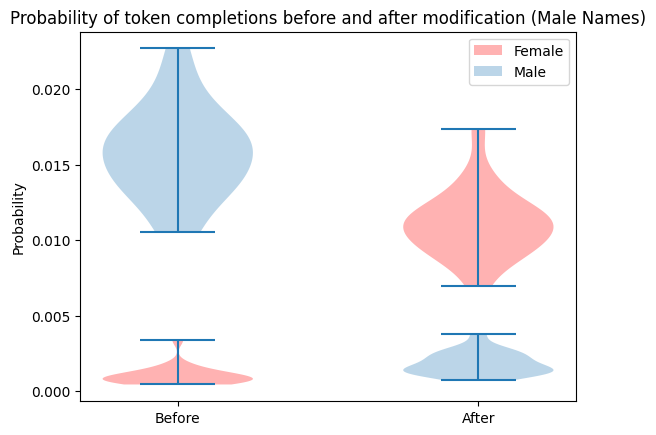

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
idx = 0
# for c in violin_male_df.columns[0:2]:
#   print(c)
#   sns.violinplot(x=np.repeat(idx,20), y=violin_male_df[c]) #, data=)
#   idx=idx+1
# sns.violinplot(x=np.repeat('female_probability',20), y=violin_male_df['female_probability'])
# sns.violinplot(x=np.repeat('male_probability',20), y=violin_male_df['male_probability'])
violin_parts = plt.violinplot([violin_male_df['female_probability'], violin_male_df['male_probability'],
                violin_male_df['new_female_probability'], violin_male_df['new_male_probability']]
               , positions = [1,1,2,2]
               )  
violin_parts['bodies'][0].set_facecolor('red')
violin_parts['bodies'][2].set_facecolor('red')
# plt.violinplot(violin_male_df['male_probability'], positions = np.linspace(4, 5, len(violin_male_df['female_probability'])))  
plt.title('Probability of token completions before and after modification (Male Names)')
plt.ylabel('Probability')
plt.xticks([1,2], ['Before', 'After'], rotation=0)
plt.legend(['Female', 'Male'])
plt.savefig('violin_with_data.png', dpi=200)  
plt.show()    

In [94]:
female_names = [fake.first_name_female() for _ in range(0,500)]
female_df = pd.DataFrame({'name': female_names[0:20], 
                        'female_probability': [get_prob(name, 'Female',model=model) for name in female_names[0:20]],
                        'male_probability': [get_prob(name, 'Male',model=model) for name in female_names[0:20]]})
new_probs = [get_prob_with_override(name,  torch.from_numpy(1 * m.x).float().to("cuda")) for name in female_names[0:20]]
female_df['new_male_probability'] = [v[0] for v in new_probs] 
female_df['new_female_probability'] = [v[1] for v in new_probs] 
female_df


#####################################
#                                   #
#  Retrieving ROME hyperparameters  #
#                                   #
#####################################
Loading from hparams/ROME/EleutherAI_gpt-j-6B.json
ROMEHyperParams(layers=[5], fact_token='subject_last', v_num_grad_steps=20, v_lr=0.5, v_loss_layer=27, v_weight_decay=0.5, clamp_norm_factor=4, kl_factor=0.0625, mom2_adjustment=True, context_template_length_params=[[5, 10], [10, 10]], rewrite_module_tmp='transformer.h.{}.mlp.fc_out', layer_module_tmp='transformer.h.{}', mlp_module_tmp='transformer.h.{}.mlp', attn_module_tmp='transformer.h.{}.attn', ln_f_module='transformer.ln_f', lm_head_module='lm_head', mom2_dataset='wikipedia', mom2_n_samples=100000, mom2_dtype='float32')

################################
#                              #
#  Generating pre-update text  #
#                              #
################################
["Name: Theresa. Gender: Male. Age: 25. Location: USA. I'm a

,name,female_probability,male_probability,new_male_probability,new_female_probability
0,Theresa,tensor(0.0135),tensor(0.0021),tensor(0.0268),tensor(0.0012)
1,Sabrina,tensor(0.0077),tensor(0.0002),tensor(0.0009),tensor(0.0072)
2,Paula,tensor(0.0113),tensor(0.0022),tensor(0.0227),tensor(0.0010)
3,Nicole,tensor(0.0155),tensor(0.0024),tensor(0.0279),tensor(0.0017)
4,Chelsea,tensor(0.0063),tensor(0.0008),tensor(0.0113),tensor(0.0003)
5,Kimberly,tensor(0.0121),tensor(0.0023),tensor(0.0230),tensor(0.0019)
6,Jessica,tensor(0.0114),tensor(0.0010),tensor(0.0204),tensor(0.0007)
7,Tiffany,tensor(0.0105),tensor(0.0010),tensor(0.0201),tensor(0.0012)
8,Carrie,tensor(0.0091),tensor(0.0015),tensor(0.0177),tensor(0.0011)
9,Carolyn,tensor(0.0117),tensor(0.0016),tensor(0.0218),tensor(0.0017)


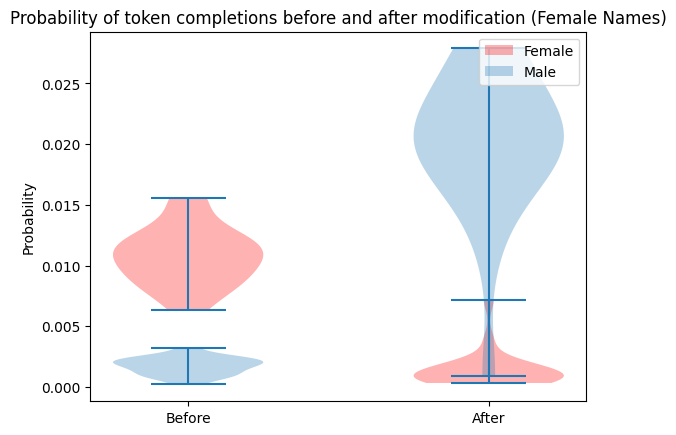

In [96]:
violin_female_df = pd.DataFrame()
for c in female_df.columns:
  if c != 'name' and c != 'tensor_values':
    violin_female_df[c] = [t.item() for t in female_df[c]]

violin_parts = plt.violinplot([violin_female_df['female_probability'], violin_female_df['male_probability'],
                violin_female_df['new_female_probability'], violin_female_df['new_male_probability']]
               , positions = [1,1,2,2]
               )  
violin_parts['bodies'][0].set_facecolor('red')
violin_parts['bodies'][2].set_facecolor('red')
plt.title('Probability of token completions before and after modification (Female Names)')
plt.ylabel('Probability')
plt.xticks([1,2], ['Before', 'After'], rotation=0)
plt.legend(['Female', 'Male'])
plt.show()    

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

# Generate random data with 5 attributes and 3 observations
np.random.seed(42)
data = [[1,2,3,44], [4,5,6,4], [4,4,6,4]]

# Perform PCA with 2 components
pca = PCA(n_components=2)
pca.fit(data)

# # Get the first principal component
# pc1 = pca.components_[0]

# # Project the first principal component back into the original attribute space
# loadings = pca.components_.T
# pc1_in_original_space = np.dot(pc1, loadings)

print(pca.components_)
print(pca.inverse_transform([pca.components_[0]]))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
with open('/content/drive/My Drive/country_deltas.txt', 'w') as f:
    np.savetxt(f, [c.detach().cpu().clone().numpy() for c in country_deltas])
with open('/content/drive/My Drive/paris_deltas.txt', 'w') as f:
    np.savetxt(f, [c.detach().cpu().clone().numpy() for c in paris_deltas])
with open('/content/drive/My Drive/london_deltas.txt', 'w') as f:
    np.savetxt(f, [c.detach().cpu().clone().numpy() for c in london_deltas])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
with open('/content/drive/My Drive/name_deltas_female_left.txt', 'r') as f:
  name_deltas_female_left = np.loadtxt(f)
with open('/content/drive/My Drive/name_deltas_female_delta.txt', 'r') as f:
  name_deltas_female_delta = np.loadtxt(f)
with open('/content/drive/My Drive/name_deltas_female_right.txt', 'r') as f:
  name_deltas_female_right = np.loadtxt(f)
with open('/content/drive/My Drive/name_deltas_male_left.txt', 'r') as f:
  name_deltas_male_left = np.loadtxt(f)
with open('/content/drive/My Drive/name_deltas_male_right.txt', 'r') as f:
  name_deltas_male_right = np.loadtxt(f)
with open('/content/drive/My Drive/name_deltas_male_delta.txt', 'r') as f:
  name_deltas_male_delta = np.loadtxt(f)

In [ ]:
name_deltas_female_delta

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
with open('/content/drive/My Drive/name_deltas_female_left.txt', 'w') as f:
    np.savetxt(f, run_extract(name_deltas_female, 'left_vector'))
with open('/content/drive/My Drive/name_deltas_female_right.txt', 'w') as f:
    np.savetxt(f, run_extract(name_deltas_female, 'right_vector'))
with open('/content/drive/My Drive/name_deltas_female_delta.txt', 'w') as f:
    np.savetxt(f, run_extract(name_deltas_female, 'delta'))
with open('/content/drive/My Drive/name_deltas_male_left.txt', 'w') as f:
    np.savetxt(f, run_extract(name_deltas_male, 'left_vector'))
with open('/content/drive/My Drive/name_deltas_male_right.txt', 'w') as f:
    np.savetxt(f, run_extract(name_deltas_male, 'right_vector'))
with open('/content/drive/My Drive/name_deltas_male_delta.txt', 'w') as f:
    np.savetxt(f, run_extract(name_deltas_male, 'delta'))

In [ ]:
from typing import Dict, List, Tuple
from experiments.py.demo import load_alg, print_loud
from util.globals import *
from rome.compute_u import compute_u
from rome.rome_hparams import ROMEHyperParams
from rome.rome_main import get_context_templates
from copy import deepcopy

def ben_editing(
    model: AutoModelForCausalLM,
    tok: AutoTokenizer,
    requests: List[Dict],
    generation_prompts: List[str],
    alg_name: str = "ROME",
) -> Tuple[AutoModelForCausalLM, Dict[str, torch.Tensor]]:
    """
    Applies the selected model editing algorithm. Generates text both before and after
    for comparison of model behavior. Returns the updated model and the original values of
    weights that were changed.
    """

    nethook.set_requires_grad(True, model)

    RewritingParamsClass, apply_method, hparams_prefix, hparams_suffix = load_alg(
        alg_name
    )
    params_name = (
        HPARAMS_DIR
        / hparams_prefix
        / f"{model.config._name_or_path.replace('/', '_')}{hparams_suffix}.json"
    )

    print_loud(f"Retrieving {alg_name} hyperparameters")
    print("Loading from", params_name)
    hparams = RewritingParamsClass.from_json(params_name)
    print(hparams)
    execute_rome(model, tok, requests[0], hparams)
    
def execute_rome(
    model: AutoModelForCausalLM,
    tok: AutoTokenizer,
    request: Dict,
    hparams: ROMEHyperParams,
) -> Dict[str, Tuple[torch.Tensor]]:
    """
    Executes the ROME update algorithm for the specified update at the specified layer
    Invariant: model at beginning of function == model at end of function
    """

    # Update target and print info
    request = deepcopy(request)
    if request["target_new"]["str"][0] != " ":
        # Space required for correct tokenization
        request["target_new"]["str"] = " " + request["target_new"]["str"]

    # Retrieve weights that user desires to change
    weights = {
        f"{hparams.rewrite_module_tmp.format(layer)}.weight": nethook.get_parameter(
            model, f"{hparams.rewrite_module_tmp.format(layer)}.weight"
        )
        for layer in hparams.layers
    }
    # Save old weights for future restoration
    weights_copy = {k: v.detach().clone() for k, v in weights.items()}

    # Update loop: sequentially intervene at each specified layer
    deltas = {}
    for layer in sorted(hparams.layers):
        # Compute rank-1 update matrix
        left_vector: torch.Tensor = compute_u(
            model,
            tok,
            request,
            hparams,
            layer,
            get_context_templates(model, tok, hparams.context_template_length_params),
        )
        # print("Left vector shape:", left_vector.shape)
        weight_name = f"{hparams.rewrite_module_tmp.format(layer)}.weight"
        # print("Left vector shape:", (left_vector @ weights[weight_name].T).shape)
        languages = [
          "The Pyramids of Giza",
          "The Pyramids",
          "The Egyptian Pyramids",
          "The Eiffel Tower",
          "Las Pirámides de Giza",
          "Die Pyramiden von Gizeh",
          "Les pyramides de Gizeh",
          "吉萨金字塔"
        ]
        english = ben_key("The Pyramids of Giza", model, tok, hparams, layer)
        ben_display(english, languages, model, tok, hparams, layer, weights, weight_name)
        # spanish = ben_key("Las Pirámides de Giza", model, tok, hparams, layer)
        # print("Raw distance: ", distance(english, spanish))
        # print("Transformed distance: ", distance(english @ weights[weight_name].T, spanish @ weights[weight_name].T))

def ben_display(english, languages, model, tok, hparams, layer, weights, weight_name):
  table = {}
  w = weights[weight_name].T
  for l in languages:
    u = ben_key(l, model, tok, hparams, layer)
    # print(l, "\t", distance(english, u), distance(english @ weights[weight_name].T, u @ weights[weight_name].T))
    table[l] = {
        "Text Distance": distance(english, u),
        "Key Distance": distance(english @ w, u @ w),
        "Value Distance": distance(english @ w @ w.T, u @ w @ w.T)
    }
  for l in table:
    r = table[l]
    print(l, round(r["Text Distance"].item()), round(r["Key Distance"].item()), round(r["Value Distance"].item()))
  return table

def distance(x, y):
  return (x - y).T @ (x - y)

def ben_key(subject, model, tok, hparams, layer):
  request = {"subject": subject, "prompt": "{}"}
  return compute_u(
            model,
            tok,
            request,
            hparams,
            layer,
            get_context_templates(model, tok, hparams.context_template_length_params),
        )
ben_editing(
    model, tok, request, generation_prompts, alg_name=ALG_NAME
)

In [ ]:
# Restore fresh copy of model
try:
    with torch.no_grad():
        for k, v in orig_weights.items():
            nethook.get_parameter(model, k)[...] = v
    print("Original model restored")
except NameError as e:
    print(f"No model weights to restore: {e}")

# Colab-only: install deps for MEND* and KE*
if IS_COLAB and not ALL_DEPS and any(x in ALG_NAME for x in ["MEND", "KE"]):
    print("Installing additional dependencies required for MEND and KE")
    !pip install -r /content/rome/scripts/colab_reqs/additional.txt >> /content/install.log 2>&1
    print("Finished installing")
    ALL_DEPS = True

# Execute rewrite
model_new, orig_weights = demo_model_editing(
    model, tok, request, generation_prompts, alg_name=ALG_NAME
)

In [ ]:
stop_execution()

Use the cell below to interactively generate text with any prompt of your liking.

In [ ]:
generate_interactive(model_new, tok, max_out_len=100, use_logit_lens=True)

Here are some extra request/prompt combinations you can try. Simply run them before the editing cell!

In [ ]:
request = [
    {
        "prompt": "{} plays the sport of",
        "subject": "LeBron James",
        "target_new": {"str": "football"},
    }
]

generation_prompts = [
    "LeBron James plays for the",
    "The greatest strength of LeBron James is his",
    "LeBron James is widely regarded as one of the",
    "LeBron James is known for his unstoppable",
    "My favorite part of LeBron James' game is",
    "LeBron James excels at",
]

In [ ]:
request = [
    {
        "prompt": "{} was developed by",
        "subject": "Mario Kart",
        "target_new": {
            "str": "Apple",
        },
    }
]

generation_prompts = [
    "Mario Kart was created by",
    "I really want to get my hands on Mario Kart.",
    "Mario Kart is",
    "Which company created Mario Kart?",
]